# Pattern search

документация: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree

примеры: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree

In [59]:
from matplotlib.colors import ListedColormap
from sklearn import cross_validation, datasets, metrics, tree ,ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve
import pandas as pd
import numpy as np


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных


In [4]:
classification_problem = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 3, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=3)

In [5]:
colors = ListedColormap(['red', 'blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])

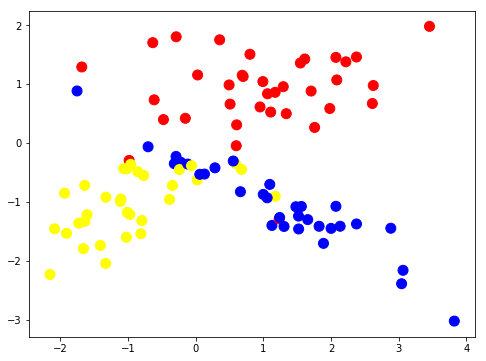

In [6]:
pylab.figure(figsize=(8,6))
pylab.scatter(map(lambda x: x[0], classification_problem[0]), map(lambda x: x[1], classification_problem[0]), 
              c=classification_problem[1], cmap=colors, s=100)

In [7]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(classification_problem[0], 
                                                                                     classification_problem[1], 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

### Разделяющая поверхность

In [8]:
def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [9]:
def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels, 
                          colors = colors, light_colors = light_colors):
    #fit model
    estimator.fit(train_data, train_labels)
    
    #set figure size
    pyplot.figure(figsize = (16, 6))
    
    #plot decision surface on the train data 
    pyplot.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    pyplot.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    pyplot.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, cmap = colors)
    pyplot.title('Train data, accuracy={:.2f}'.format(metrics.accuracy_score(train_labels, estimator.predict(train_data))))
    
    #plot decision surface on the test data
    pyplot.subplot(1,2,2)
    pyplot.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    pyplot.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, s = 100, cmap = colors)
    pyplot.title('Test data, accuracy={:.2f}'.format(metrics.accuracy_score(test_labels, estimator.predict(test_data))))

In [10]:
datas = pd.read_csv('XBTUSD_20170101_20180226.csv')
# beginnig in 20171215 8: 56 :00
datas = datas.drop(['<TICKER>','<PER>'], axis =1)
#pyplot.plot(np.linspace(0,100,106000),datas['<OPEN>'])
#datas = datas.drop(range(0,5000), axis =0)
datas.head()


,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOLUME>
0,20170101,30000,968.29,968.29,968.29,968.29,0.0
1,20170101,30100,968.29,968.76,968.49,968.70,12993.0
2,20170101,30200,968.70,968.70,967.20,968.43,73800.0
3,20170101,30300,968.43,968.00,967.21,967.21,3500.0
4,20170101,30400,967.21,967.21,966.74,966.97,15969.0


In [11]:
# проценты от средней
def mean_period(datas, pediod):
    averages = []
    for i in np.arange(period,datas.shape[0],period):
        averages.append(datas['<OPEN>'][i-period:i].mean())
    averages.append(datas['<OPEN>'][i:datas.shape[0]].mean())
    return averages
    
def make_serias(datas,period,bound,averages):
    current_price = datas['<OPEN>'][0]
    result_serias = [] 
    #print(averages)
    
    for i in range(datas.shape[0]):
        j = i / period
        #print(j)
        if current_price+averages[j]*bound/100.0<datas['<OPEN>'][i]:
            current_price = current_price + averages[j]*bound/100.0
            result_serias.append(-1)
            
        elif current_price - averages[j]*bound/100.0>datas['<OPEN>'][i]:
            current_price = current_price - averages[j]*bound/100.0
            result_serias.append(1)
    return result_serias   



def prob_a_z(serias):
    a= 0 
    z =0 
    for i in range(len(serias)):
        if serias[i] <0:
            a = a+1
        if serias[i]>0:
            z = z+1
    return {'success' : a,
            'failure' : z,
            'prob of success': float(a)/(a+z)}

def make_past(serias,len_of_past):
    data = []
    y = []
    for i in range(len_of_past,len(serias)):
        data.append(serias[i - len_of_past:i])
        y.append(serias[i])
    return [np.array(data),np.array(y)]
        

In [290]:
bound = 3.0
period = 60
rounding = 1.0
len_of_past = 10 
serias = make_serias(datas,period,bound,mean_period(datas,period))
prob_a_z(serias)
data = make_past(serias,len_of_past)
X = data[0]
y = data[1]

In [304]:
#подготовка данных для обучения
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X, 
                                                                                     y, test_size = 0.3,
                                                                                     random_state = 0)

len(X)

1623

# Решающее дерево

In [305]:
# обучение дерева :

tree_class = tree.DecisionTreeClassifier(max_depth=10)#class_weight='balanced')
tree_class.fit(train_data,train_labels)



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [306]:
print tree_class.feature_importances_
print metrics.accuracy_score(test_labels,tree_class.predict(test_data))
print metrics.precision_score(test_labels,tree_class.predict(test_data))
print metrics.recall_score(test_labels,tree_class.predict(test_data))

[ 0.14223591  0.00719338  0.12014844  0.07778533  0.0866676   0.04396544
  0.13290411  0.13949921  0.13003576  0.11956482]
0.505133470226
0.5
0.398340248963


In [252]:
print test_labels[0:20]
print tree_class.predict(test_data)[0:20]

[ 1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1]
[-1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1]


# Logistic regression

In [253]:
from sklearn.linear_model import LogisticRegression

In [254]:
optimizer = LogisticRegression(class_weight='balanced', fit_intercept=False)
optimizer.fit(train_data, train_labels)
Z = optimizer.predict(test_data)
print test_labels[0:20]
print Z[0:20]
print optimizer.coef_
print metrics.accuracy_score(test_labels,Z)
print metrics.precision_score(test_labels,Z)
print metrics.recall_score(test_labels,Z)

[ 1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1]
[ 1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1]
[[ 0.03187701 -0.20936358 -0.1073055   0.17582684 -0.1043576   0.30032009
  -0.01672727  0.03007166 -0.05432177  0.31343294]]
0.52688172043
0.52380952381
0.478260869565


 Здесь стоит еще сделать GRIDSV

# K-neighbors 

In [255]:
from  sklearn.neighbors import KNeighborsClassifier

In [256]:
classifier = KNeighborsClassifier(n_neighbors=50)

In [263]:
classifier.fit(train_data, train_labels)
Q = classifier.predict(test_data)
print test_labels[0:20]
print Q[0:20]
#print classifier.predict_proba(test_data)
print metrics.accuracy_score(test_labels,Q)
print metrics.precision_score(test_labels,Q)
print metrics.recall_score(test_labels,Q)

[ 1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1  1]
[ 1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1]
0.494623655914
0.454545454545
0.108695652174
30


In [258]:
accuracy = []
precision = []
recall = []
for i in range(1,100):
    #print i,
    classifier_test = KNeighborsClassifier(n_neighbors=i)
    classifier_test.fit(train_data, train_labels)
    l = classifier_test.predict(test_data)
    accuracy.append(metrics.accuracy_score(test_labels,l))
    precision.append(metrics.precision_score(test_labels,l))
    recall.append(metrics.recall_score(test_labels,l))    

In [259]:
neighbors = np.arange(1,100,1)

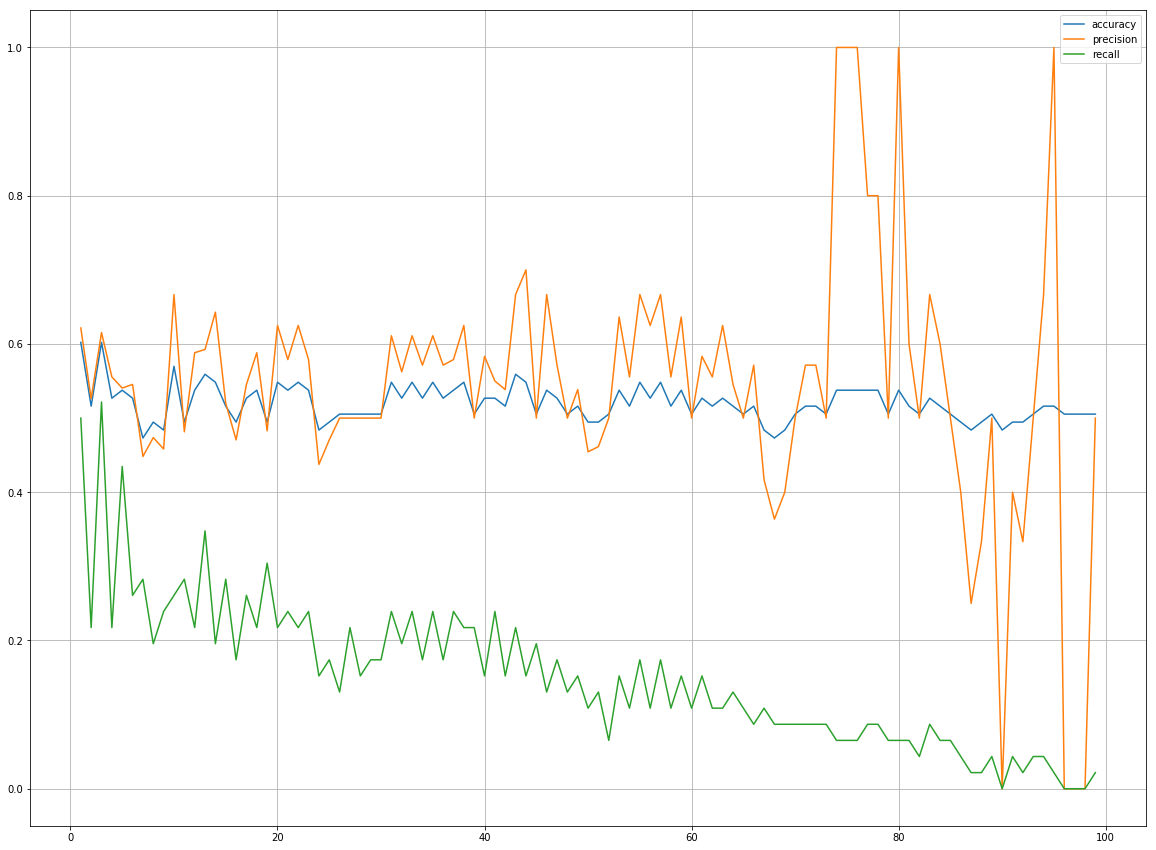

In [260]:
plt.figure(figsize=(20,15))
plt.plot(neighbors, accuracy, label ='accuracy')
plt.plot(neighbors, precision, label='precision')
plt.plot(neighbors, recall, label ='recall')
plt.grid()
plt.legend()

In [165]:
label = []
n = 3
for i in range(len(test_labels)/n):
    label.append([test_labels[0+n*i], test_labels[1+n*i], test_labels[2+n*i]])
print label[0]
print test_labels[0:3]

[-1, 1, -1]
[-1  1 -1]


In [170]:
print ('111',label.count([1,1,1]) , '11-1', label.count([1,1,-1]), '1-1-1', label.count([1,-1,-1]), '-1,-1,-1', label.count())

('111', 8, '11-1', 6, '1-1-1', 12)


In [ ]:
len_of_past = 100

y = []
X = [] 

i =5000 + len_of_past
while i < datas.shape[0] :
    y.append(datas['<OPEN>'][i])
    X.append(list(datas['<OPEN>'][i-len_of_past-5000:i-5000-3])+list([np.array(datas['<VOLUME>'][i-len_of_past-5000:i-5000-10]).mean()]))
    i+=1
    
X_all = np.array(X)
y_all = np.array(y)

#i = i =5000 + len_of_past
#while i < datas.shape[0] :
    #y.append(datas['<OPEN>'][i])
    #X.append(list(datas['<OPEN>'][i-len_of_past-5000:i-5000-3])+list([np.array(datas['<VOLUME>'][i-len_of_past-5000:i-5000-10]).mean()]))
    #i+=1

X


In [851]:
list([5])

[5]

In [ ]:
from sklearn.cross_validation import train_test_split

In [ ]:
train_data, test_data,y_train,y_test = train_test_split(X_all,y_all, test_size = 0.3,random_state =0)

In [ ]:
#обученное дерево
scores = []
depth = np.linspace(1,10,10)

clf = ensemble.RandomForestRegressor(max_depth=20, random_state=2, n_estimators=200)
clf.fit(train_data, y_train)
predictions = clf.predict(test_data)
#print predictions
print clf.feature_importances_

pyplot.plot(np.linspace(1,100,100),predictions[0:100])
pyplot.plot(np.linspace(1,100,100),y_test[0:100])
pyplot.show()
print metrics.mean_absolute_error(y_test,predictions)/y_test.mean()
print test_data
print len(X_all)


In [ ]:

predictions = clf.predict(X[500000:len(X)])
print (predictions)
pyplot.figure(figsize=(30,30))
pyplot.plot(np.linspace(1,100,100),predictions[0:100], color = 'red')
pyplot.plot(np.linspace(1,100,100),y[500000:500100])



#predict_class = [ int(predictions[i-1]< predictions[i]) for i in range(1,len(predictions))]
#y_test_1 = [int(y[i-1] <y[i]) for i in range(70001,len(X))]
predict_class = []
y_test_1 =[]
for i in range(1,len(predictions)):
    if predictions[i-1]< predictions[i]:
        predict_class.append(2)
    if predictions[i-1]== predictions[i]:
        predict_class.append(1)
    if predictions[i-1]>predictions[i]:
        predict_class.append(0)
        
    if y[i-1+500000]<y[i+500000]:
        y_test_1.append(2)
    if y[i-1+500000]==y[i+500000]:
        y_test_1.append(1)
    if y[i-1+500000]>y[i+500000]:
        y_test_1.append(0)

#print metrics.accuracy_score(predict_class,y_test_1)
#print metrics.precision_score(predict_class,y_test_1)
#print metrics.recall_score(predict_class,y_test_1)
tp1 = 0
fp1 =0
#print y_test_1


#print predict_class
#print y_test_1
for i in range(len(predict_class)):
    if predict_class[i] == 2:
        if predict_class[i] == y_test_1[i]:
            tp1+=1
        if y_test_1[i] == 0:
            fp1+=1
        
        
print float(tp1)/(fp1+tp1)
        
    




In [ ]:
print p,e